In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
from os import path

from chemprop.features import BatchMolGraph, MolGraph
from chemprop.data.data import MoleculeDatapoint, MoleculeDataset
from chemprop.data import MoleculeDataLoader, split_data
from chemprop.nn_utils import get_activation_function, initialize_weights, NoamLR
import torch
from chemprop.utils import build_lr_scheduler
from torch.nn.parameter import Parameter
td = torch.distributions
from chemprop.args import TrainArgs, HyperoptArgs
from chemprop.features.featurization import get_atom_fdim, get_bond_fdim
from tqdm import tqdm
from chemprop.train import cross_validate, run_training
from chemprop.models.model import BayesianMoleculeModel
from chemprop.features.featurization import BatchMolGraph
from torch.optim.lr_scheduler import _LRScheduler

In [2]:
class BayesianArgs(TrainArgs):
    prior = td.Normal(0,1)
    data_path = "data/hiv.csv"
    init = 'zeros' # Changed from 'xavier' sometimes produces nans :o
    init_lr = 1e-4  #5e-3
    max_lr = 1e-3   #1e-2
    final_lr = 1e-6 #1e-5
    split_sizes = (0.8, 0.1, 0.1)
    train_data_size = 9880*split_sizes[0]  #642*split_sizes[0]
    epochs = 100
    warmup_epochs = 2
    
args = BayesianArgs()
args.ffn_hidden_size = 1000
args.hidden_size = 1000
args.ffn_num_layers = 3
args.depth = 6
args.dropout = 0.0 # Changed from 0.15
args.num_workers = 0
args.batch_size = 50 #200 # Changed from 50
args.dataset_type = 'classification'

C:\Users\snowy\Anaconda3\envs\pytorch\lib\site-packages\tap\tap.py:304: UserWarning: add_arguments is deprecated and will be removed on January 1st, 2021 please override "configure" instead and call add_argument there. 
  warn('add_arguments is deprecated and will be removed on January 1st, 2021'


In [3]:
load_trained = False
device = torch.device('cuda')
mod = BayesianMoleculeModel(args, device=device)

path_name = args.data_path.partition("/")[2].partition(".")[0]
path_name += f"_hidden_{args.ffn_hidden_size}"
path_name += f"_ffn_num_{args.ffn_num_layers}"
path_name += f"_depth_{args.depth}"
path_name += f"_dropout_{args.dropout}"
path_name += f"_epochs_{args.epochs}"

checkpoints = os.listdir("Checkpoints/")
max_epochs = 0
for check in checkpoints:
    if check.startswith(path_name.partition("epochs_")[0]):
        if int(check.partition("epochs_")[2].partition(".")[0]) > max_epochs:
            max_epochs = int(check.partition("epochs_")[2].partition(".")[0])
            path_name = check


if load_trained and path.exists(f"Checkpoints/{check}"):
    print("Checkpoint found:", f"Checkpoints/{check}")
    mod.load_state_dict(torch.load(f"Checkpoints/{check}"))

In [4]:
# Number of parameter objects in mod (2*3 for MPN, 2*2*(ffm_num_layers-1) for FFN, 2*2 for FFN_mean, 2*2 for FFN_std)
len([param for param in mod.parameters()])

18

In [5]:
from chemprop.data import get_data
data = get_data(
        path=args.data_path,
        args=args,
        skip_none_targets=True)
train_data, val_data, test_data = split_data(data=data, 
                                             split_type=args.split_type, 
                                             sizes=args.split_sizes, 
                                             seed=args.seed, 
                                             num_folds=args.num_folds, 
                                             args=args, 
                                             logger=None)

41127it [00:00, 178515.65it/s]
100%|██████████████████████████████████████████████████████████████████████████| 41127/41127 [00:18<00:00, 2247.98it/s]


In [6]:
def train(model: BayesianMoleculeModel,
          data_loader: MoleculeDataLoader,
          optimizer,
          args: TrainArgs,
          n_iter) -> int:
    """
    Trains a model for an epoch.

    :param model: A :class:`~chemprop.models.model.MoleculeModel`.
    :param data_loader: A :class:`~chemprop.data.data.MoleculeDataLoader`.
    :param loss_func: Loss function.
    :param optimizer: An optimizer.
    :param args: A :class:`~chemprop.args.TrainArgs` object containing arguments for training the model.
    :param n_iter: The number of iterations (training examples) trained on so far.
    :return: The total number of iterations (training examples) trained on so far.
    """
    model.to(device)
    model.training_mode(True)
    model.sampling_mode(True)
    model.train()
    loss_sum = iter_count = 0
    num_batches = len(data_loader)
    
    for b, batch in enumerate(tqdm(data_loader, total=len(data_loader), leave=False, disable=True)):
        # Prepare batch
        batch: MoleculeDataset
        mol_batch, features_batch, target_batch, atom_descriptors_batch = \
            batch.batch_graph(), batch.features(), batch.targets(), batch.atom_descriptors()
        
        
        target_batch = torch.Tensor(target_batch).to(device)
        
        kl_weight_batch = (2**(num_batches-b))/(2**num_batches - 1)
        
        # Run model
        model.zero_grad()
        #nll = model.nll(mol_batch[0], target_batch)
        loss = model.elbo(mol_batch[0], target_batch, num_batches, num_samples=1) 
        
        # In case elbo spikes or becomes nan stop training before optimizer steps (for debug)
        if torch.isnan(loss):
            raise ValueError("Loss is nan")
        
        if loss > 1e11:
            raise ValueError("Loss spiked")
        
        loss_sum += loss.item()
        iter_count += 1
        
        loss.backward()
        if args.grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.grad_clip)
        optimizer.step()
        
        if isinstance(scheduler, NoamLR):
            scheduler.step()
        
        n_iter += len(batch)
    return loss_sum / num_batches

In [9]:
init_lr = 1e-4  #5e-3
max_lr = 5e-4   #1e-2
final_lr = 1e-5 #1e-5
epochs = args.epochs
optimizer = torch.optim.Adam(params=mod.parameters(), lr=args.init_lr)
scheduler = build_lr_scheduler(optimizer, args)
train_data_loader = MoleculeDataLoader(dataset=train_data,batch_size=args.batch_size,num_workers=args.num_workers,
                                       class_balance=args.class_balance,shuffle=True,seed=args.seed)
val_data_loader = MoleculeDataLoader(dataset=val_data,batch_size=args.batch_size,num_workers=args.num_workers)
test_data_loader = MoleculeDataLoader(dataset=test_data,batch_size=len(test_data),num_workers=args.num_workers)

if "loss_lst" not in globals():
    loss_lst = []
    loss_val = []
for n_iter in range(epochs):
    # Training
    loss_sum = train(model=mod,
                   data_loader=train_data_loader,
                   optimizer=optimizer,
                   args=args,
                   n_iter=n_iter)
    loss_lst.append(loss_sum)
    
    # Validation
    mod.eval()
    batch_val = next(iter(val_data_loader))
    mol_batch, features_batch, target_batch, atom_descriptors_batch = \
            batch_val.batch_graph(), batch_val.features(), batch_val.targets(), batch_val.atom_descriptors()
    target_batch = torch.Tensor(target_batch).to(device)
    with torch.no_grad():
        loss = mod.elbo(mol_batch[0], target_batch, args.batch_size, num_samples=1) 
    loss_val.append(loss)
    
    print(f"Epoch {n_iter+1} loss {loss_sum} val loss {loss}")

Epoch 1 loss 44423.465234967756 val loss 560865.875
Epoch 2 loss 40895.24305884863 val loss 518943.15625
Epoch 3 loss 38138.87977167109 val loss 487715.4375
Epoch 4 loss 36085.49560769158 val loss 464438.0625
Epoch 5 loss 34555.39872794954 val loss 447104.84375
Epoch 6 loss 33415.469271623675 val loss 434259.03125
Epoch 7 loss 32566.125385290212 val loss 424559.15625
Epoch 8 loss 31933.476455804248 val loss 417430.6875
Epoch 9 loss 31461.966310816577 val loss 412036.90625
Epoch 10 loss 31110.653209171094 val loss 408061.46875
Epoch 11 loss 30848.759611508915 val loss 405155.15625
Epoch 12 loss 30653.77244760053 val loss 402869.28125
Epoch 13 loss 30508.24929165876 val loss 401237.03125
Epoch 14 loss 30399.883316341045 val loss 400061.21875
Epoch 15 loss 30319.223020793816 val loss 399090.34375
Epoch 16 loss 30258.961811812405 val loss 398399.1875
Epoch 17 loss 30214.15149611153 val loss 397929.75
Epoch 18 loss 30180.696456515554 val loss 397503.125
Epoch 19 loss 30155.750560152694 val 

In [14]:
# Checkpoint training
save_path = path_name.partition("epochs_")[0] + f"epochs_{n_iter + max_epochs + 1}.pt"



# Make sure we never overwrite a model
if not path.exists(f"Checkpoints/{save_path}"):
    print("Saving model at", f"Checkpoints/{save_path}")
    torch.save(mod.state_dict(), f"Checkpoints/{save_path}")

Text(0, 0.5, 'Elbo Loss')

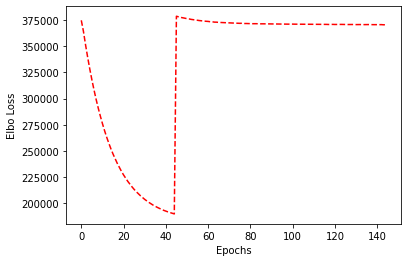

In [21]:
plt.plot(loss_val, 'r--')
plt.xlabel('Epochs')
plt.ylabel('Elbo Loss')

Text(0, 0.5, 'Elbo Loss')

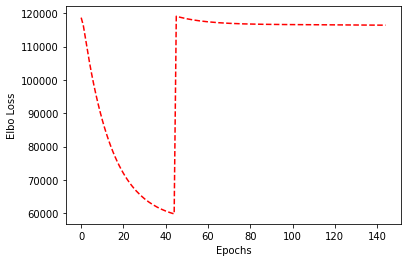

In [22]:
plt.plot(loss_lst, 'r--')
plt.xlabel('Epochs')
plt.ylabel('Elbo Loss')

# Sample Predictions

In [23]:
mod.load_state_dict(torch.load(f"Checkpoints/pdbbind_full_hidden_1000_ffn_num_3_depth_6_dropout_0.0_epochs_600.pt"))
test_data_loader = MoleculeDataLoader(dataset=test_data,batch_size=len(test_data),num_workers=args.num_workers)
mod.sampling_mode(True)
mod.training_mode(False)
num_samples = 200
batch = next(iter(test_data_loader))
y_pred_s = np.empty((num_samples, len(test_data), args.num_tasks))
mol_batch, features_batch, target_batch, atom_descriptors_batch = \
            batch.batch_graph(), batch.features(), batch.targets(), batch.atom_descriptors()

for s in range(num_samples):
    y_pred_mean, y_pred_std = mod.forward(mol_batch[0])
    y_pred_s[s] = td.Normal(y_pred_mean, y_pred_std).sample().cpu().numpy()

Label =  [6.74]


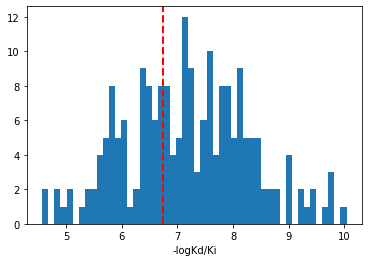

In [47]:
# Have a look at a random test data point
index = np.random.randint(0, len(test_data))
plot = plt.hist(y_pred_s[:, index], bins = 50)
plt.xlabel('-logKd/Ki')
plt.axvline(x=target_batch[index], color='r', linestyle='dashed', linewidth=2)
print("Label = ", target_batch[index])

In [48]:
pred_ints = np.linspace(0, 1, 100)[1:]

In [49]:
y_test = np.array(target_batch)
icp = []
for pred_int in pred_ints:
    p_upper = 1 - (1-pred_int)/2
    p_lower = p_upper - pred_int
    q1 = np.quantile(y_pred_s, p_lower, axis=0)
    q2 = np.quantile(y_pred_s, p_upper, axis=0)
    
    icp.append(np.mean(np.logical_and(y_test < q2, y_test > q1)))

(-0.05, 1.05, -0.05, 1.05)

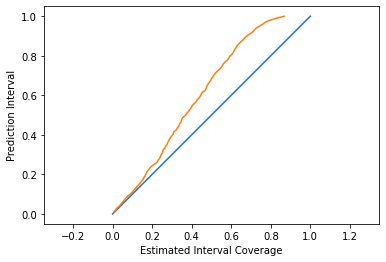

In [50]:
x_perf = np.linspace(0, 1, 1000)
plt.plot(x_perf, x_perf)
plt.plot(icp, pred_ints)
plt.xlabel('Estimated Interval Coverage')
plt.ylabel('Prediction Interval')
plt.axis('equal')

In [51]:
aggregate_every = 10
rmse = np.empty(len(test_data) // aggregate_every)
sigma = np.empty(len(test_data) // aggregate_every)

y_pred = y_pred_mean.cpu().numpy()

for i in range(len(test_data) // aggregate_every):
    y_test_agr = y_test[i*aggregate_every:(i+1)*aggregate_every]
    y_pred_s_agr = y_pred_s[:,i*aggregate_every:(i+1)*aggregate_every]
    y_pred_agr = y_pred[i*aggregate_every:(i+1)*aggregate_every]
    
    sigma[i] = np.mean(np.std(y_pred_s_agr, axis=0))
    rmse[i] = np.sqrt(np.mean((y_pred_agr - y_test_agr)**2)).squeeze()

Text(0, 0.5, 'RMSE')

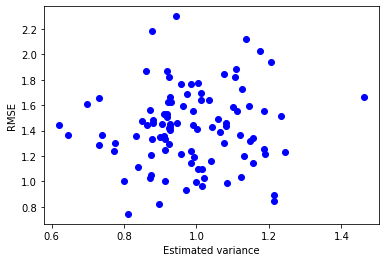

In [52]:
plt.plot(sigma, rmse, 'bo')
plt.xlabel('Estimated variance')
plt.ylabel('RMSE')

# Mean Predictions

In [ ]:
sigma